<a href="https://colab.research.google.com/github/Abdouramane-qr/Classroom/blob/main/Projet_stat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%ls /content/gdrive/MyDrive/drive/statistiques/Devoir_stat/

ls: cannot access '/content/gdrive/MyDrive/drive/statistiques/Devoir_stat/': No such file or directory


In [5]:
!pip install prince
!pip install gower



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 5.9 MB/s eta 0:00:00


# Projet : Classification non supervisée de conceptions moteur

In [7]:


# Auteur : Data Scientist - Projet interne
# Objectif : EDA + CAH + ACP/ACM sur des conceptions moteur

import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
import prince  # Pour ACM
import gower

In [8]:
# --- 1. Chargement des données ---
df = pd.read_csv('/content/gdrive/MyDrive/gdrive/dataset_anon.csv')

In [6]:
print(df.head())



       Y1          Y2 experiment_date    feat_A  feat_B  feat_C      feat_D  \
0  4.1160  707.466667      2017-08-27  1.291545     NaN     NaN  367.276355   
1  4.0572  827.400000      2017-03-24  1.291545     NaN     NaN  375.817665   
2  5.3228  811.533333      2017-03-10  0.604668     NaN     NaN  193.603040   
3  4.6396  684.600000      2017-03-10       NaN     NaN     NaN   45.553656   
4  3.9004  723.800000      2017-08-29  2.665300     NaN     NaN  726.011399   

     feat_E    feat_F       feat_G  ... feat_M    feat_N feat_O feat_P  \
0  1.822915  4.889539        myers  ...    lit       NaN  proxy    NaN   
1  1.822915  4.889539  competition  ...    lit  mountain  proxy    NaN   
2  1.822915  4.889539  competition  ...    lit  mountain  proxy    NaN   
3  5.468744  0.000000  competition  ...    lit       NaN  proxy    NaN   
4  1.822915  4.889539        myers  ...    lit  mountain  proxy    NaN   

       feat_Q feat_R   feat_S   feat_T     feat_U     feat_V  
0  conference    

In [9]:
# Conversion de la date
df['experiment_date'] = pd.to_datetime(df['experiment_date'])


In [10]:
# Identification des colonnes par type
numeric_features = ['feat_A', 'feat_B', 'feat_C', 'feat_D', 'feat_E', 'feat_F']
categorical_features = [f'feat_{c}' for c in 'GHIJKLMNOPQRSTUV']

Gestion des valeurs manquantes

In [11]:
# - Remplacer 'NULL' par NaN pour les features numériques
df[numeric_features] = df[numeric_features].replace('NULL', np.nan)

In [12]:
# - Convertir les numériques en float
for col in numeric_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [13]:
df.columns

Index(['Y1', 'Y2', 'experiment_date', 'feat_A', 'feat_B', 'feat_C', 'feat_D',
       'feat_E', 'feat_F', 'feat_G', 'feat_H', 'feat_I', 'feat_J', 'feat_K',
       'feat_L', 'feat_M', 'feat_N', 'feat_O', 'feat_P', 'feat_Q', 'feat_R',
       'feat_S', 'feat_T', 'feat_U', 'feat_V'],
      dtype='object')

Pour chaque caractéristique quantitative (par exemple feat_A), nous avons créé une nouvelle colonne nommée feat_A_applicable (ou similaire) qui prend :

la valeur 1 si la caractéristique feat_A était applicable (c'est-à-dire qu'il y avait une valeur numérique, pas un NaN à l'origine)
la valeur 0 si la caractéristique feat_A n'était pas applicable (c'est-à-dire qu'elle était initialement NULL, donc devenue NaN puis remplacée par 0)

In [14]:
# - Créer des colonnes binaires d'applicabilité pour les variables numériques  (1 si applicable, 0 sinon)
for col in numeric_features:
    df[f'{col}_applicable'] = df[col].notnull().astype(int)

In [15]:
# - Gestion des catégorielles : remplacer NULL par 'N/A'
df[categorical_features] = df[categorical_features].fillna('N/A')

In [14]:
df.columns

Index(['Y1', 'Y2', 'experiment_date', 'feat_A', 'feat_B', 'feat_C', 'feat_D',
       'feat_E', 'feat_F', 'feat_G', 'feat_H', 'feat_I', 'feat_J', 'feat_K',
       'feat_L', 'feat_M', 'feat_N', 'feat_O', 'feat_P', 'feat_Q', 'feat_R',
       'feat_S', 'feat_T', 'feat_U', 'feat_V', 'feat_A_applicable',
       'feat_B_applicable', 'feat_C_applicable', 'feat_D_applicable',
       'feat_E_applicable', 'feat_F_applicable'],
      dtype='object')

In [16]:
# Vérification des colonnes constantes
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print(f"Colonnes constantes: {constant_cols}")

Colonnes constantes: ['feat_E_applicable', 'feat_F_applicable']


In [17]:
# Extraction des features temporelles
df['experiment_year'] = df['experiment_date'].dt.year
df['experiment_month'] = df['experiment_date'].dt.month

In [18]:
# 5. Suppression des colonnes constantes
#constant_cols = []
#for col in df.columns:
#    if df[col].nunique() == 1:
#        constant_cols.append(col)
#        print(f"Colonne constante détectée: {col} - Valeur unique: {df[col].iloc[0]}")

In [19]:
# 5. Vérification finale
print("\n=== Résumé des données nettoyées ===")
print(f"Shape: {df.shape}")
print(f"Types:\n{df.dtypes}")
print(f"\nValeurs manquantes:\n{df.isnull().sum()}")
print(f"\nExemple de données:\n{df.head(2)}")


=== Résumé des données nettoyées ===
Shape: (163, 33)
Types:
Y1                          float64
Y2                          float64
experiment_date      datetime64[ns]
feat_A                      float64
feat_B                      float64
feat_C                      float64
feat_D                      float64
feat_E                      float64
feat_F                      float64
feat_G                       object
feat_H                       object
feat_I                       object
feat_J                       object
feat_K                       object
feat_L                       object
feat_M                       object
feat_N                       object
feat_O                       object
feat_P                       object
feat_Q                       object
feat_R                       object
feat_S                       object
feat_T                       object
feat_U                       object
feat_V                       object
feat_A_applicable             int64
fe

In [20]:
# Suppression des colonnes constantes (DERNIER)
#constant_cols = [col for col in df.columns if df[col].nunique() == 1]
#print(f"Colonnes constantes à supprimer: {constant_cols}")
#df = df.drop(columns=constant_cols)  # Suppression finale

In [21]:
# Configuration initiale
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

1. Analyse Univariée

Quantitatives :

Distribution des performances (Y1, Y2) : Asymétrie, valeurs extrêmes

Analyse des features numériques : Valeurs centrales, dispersion

Taux d'applicabilité : % de conceptions où chaque feature est pertinente

In [22]:
# Analyse des variables quantitatives
quant_vars = ['Y1', 'Y2'] + [f'feat_{c}' for c in 'ABCDEF']
print("\nStatistiques descriptives (quantitatives):")
print(df[quant_vars].describe().T)


Statistiques descriptives (quantitatives):
        count        mean         std         min         25%         50%  \
Y1      163.0    4.280316    1.373060    1.234800    3.224200    4.298000   
Y2      163.0  717.154008  211.010163  282.800000  580.066667  696.733333   
feat_A  153.0    1.257822    0.488035    0.318019    1.261258    1.291545   
feat_B   71.0  476.301304  155.263428  244.583133  314.464028  552.145344   
feat_C   36.0    2.864713    0.508129    1.550790    3.022871    3.092007   
feat_D  135.0  347.656648  151.274713   42.706553  337.381768  368.699907   
feat_E  163.0    2.035402    0.754947    0.000000    1.822915    1.822915   
feat_F  163.0    4.979531    1.533980    0.000000    4.889539    4.889539   

               75%          max  
Y1        5.230960    10.099600  
Y2      820.575000  1600.666667  
feat_A    1.291545     3.220210  
feat_B  626.986920   689.318953  
feat_C    3.092007     3.475982  
feat_D  375.817665   882.602093  
feat_E    1.822915     5

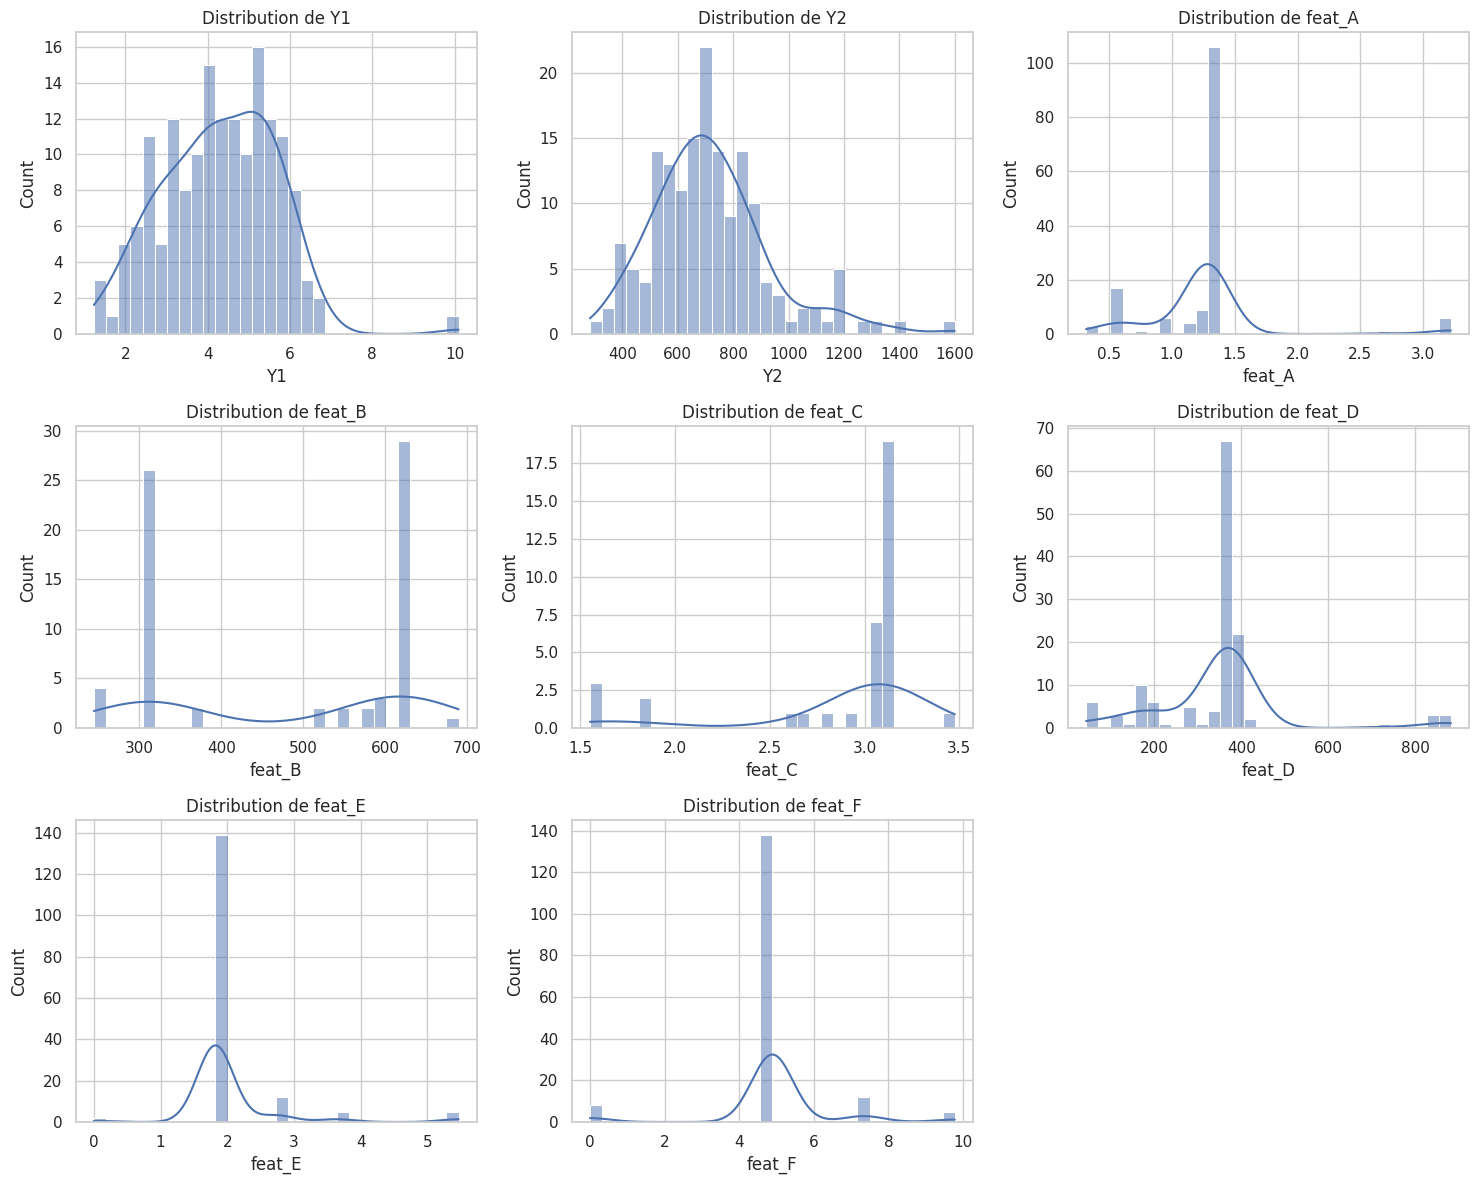

In [23]:
## Visualisation distributions quantitatives

# Exemple : liste de variables quantitatives
# Remplace cela par ta propre liste
# quant_vars = ['age', 'revenu', 'taille', ...]

# Nombre de variables quantitatives
n_vars = len(quant_vars)

# Définir le nombre de colonnes (par exemple, 3)
n_cols = 3
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

# S'assurer que axes est un tableau plat (même s'il n'y a qu'une seule ligne)
axes = axes.flatten()

# Tracer les histogrammes
for i, var in enumerate(quant_vars):
    sns.histplot(df[var], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribution de {var}')

# Supprimer les axes inutilisés
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('distributions_quantitatives.png')
plt.show()


# **Analyse des applicabilités**

In [25]:

# Liste dynamique de colonnes existantes contenant "applicable"
app_vars = [col for col in df.columns if 'applicable' in col and df[col].dtype != 'object']
print("\nTaux d'applicabilité des features :")
print(df[app_vars].mean().sort_values(ascending=False))
print("Colonnes d'applicabilité utilisées :", app_vars)


Taux d'applicabilité des features :
feat_E_applicable    1.000000
feat_F_applicable    1.000000
feat_A_applicable    0.938650
feat_D_applicable    0.828221
feat_B_applicable    0.435583
feat_C_applicable    0.220859
dtype: float64
Colonnes d'applicabilité utilisées : ['feat_A_applicable', 'feat_B_applicable', 'feat_C_applicable', 'feat_D_applicable', 'feat_E_applicable', 'feat_F_applicable']


In [26]:
df.columns

Index(['Y1', 'Y2', 'experiment_date', 'feat_A', 'feat_B', 'feat_C', 'feat_D',
       'feat_E', 'feat_F', 'feat_G', 'feat_H', 'feat_I', 'feat_J', 'feat_K',
       'feat_L', 'feat_M', 'feat_N', 'feat_O', 'feat_P', 'feat_Q', 'feat_R',
       'feat_S', 'feat_T', 'feat_U', 'feat_V', 'feat_A_applicable',
       'feat_B_applicable', 'feat_C_applicable', 'feat_D_applicable',
       'feat_E_applicable', 'feat_F_applicable', 'experiment_year',
       'experiment_month'],
      dtype='object')

In [27]:
# Analyse des variables catégorielles
cat_vars = [c for c in df.columns if c.startswith('feat_') and c not in quant_vars + app_vars] + ['experiment_year', 'experiment_month']

In [28]:
df[cat_vars].columns



Index(['feat_G', 'feat_H', 'feat_I', 'feat_J', 'feat_K', 'feat_L', 'feat_M',
       'feat_N', 'feat_O', 'feat_P', 'feat_Q', 'feat_R', 'feat_S', 'feat_T',
       'feat_U', 'feat_V', 'experiment_year', 'experiment_month'],
      dtype='object')


Top 5 des modalités par variable catégorielle:

feat_G:
feat_G
myers          0.539877
size           0.122699
les            0.116564
boots          0.073620
competition    0.067485
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


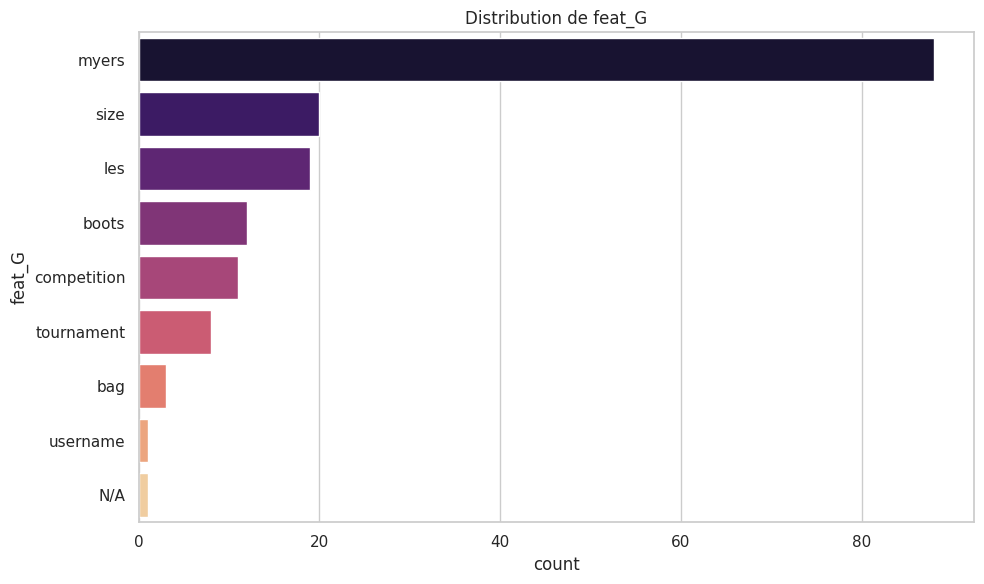


feat_H:
feat_H
N/A          0.680982
switching    0.134969
integrate    0.073620
tablets      0.073620
cow          0.024540
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


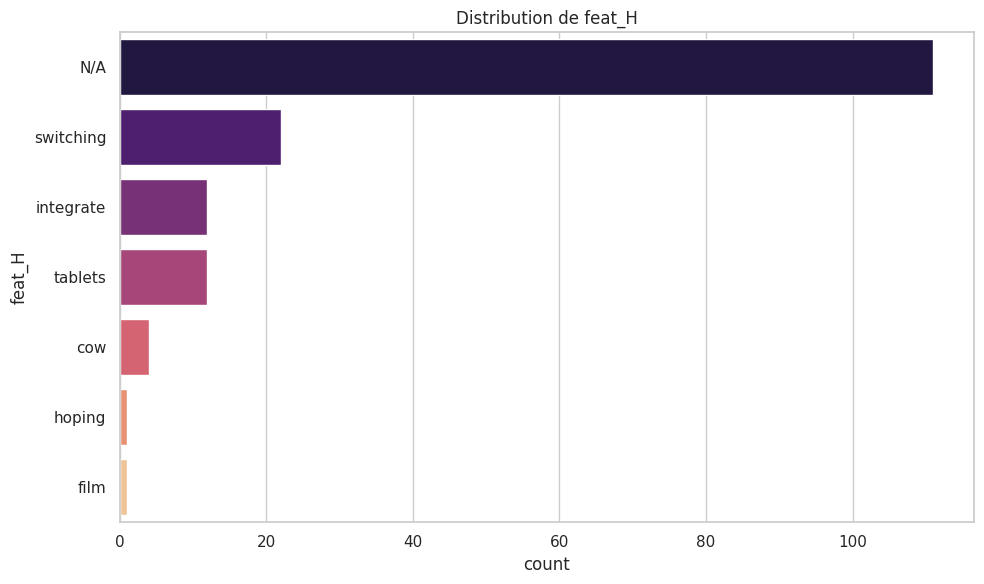


feat_I:
feat_I
N/A         0.760736
mfg         0.085890
cisco       0.061350
worth       0.055215
finances    0.024540
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


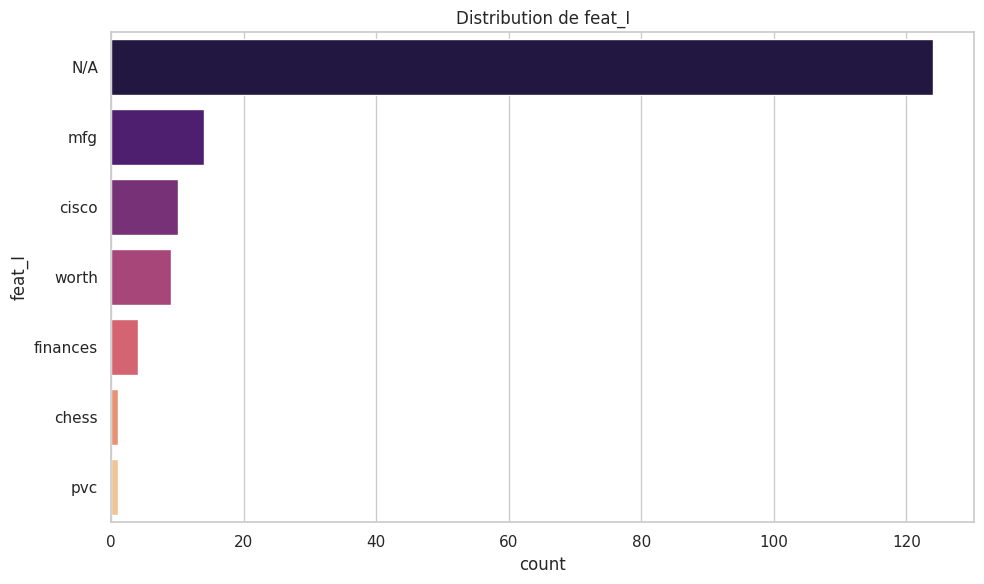


feat_J:
feat_J
gr         0.803681
issued     0.134969
N/A        0.036810
coleman    0.024540
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


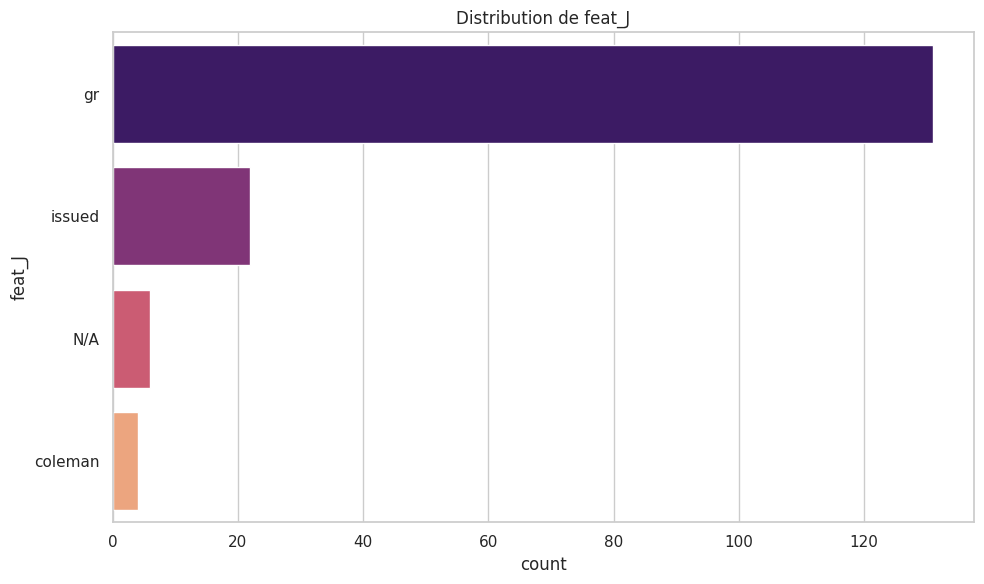


feat_K:
feat_K
eh       0.846626
enemy    0.092025
N/A      0.061350
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


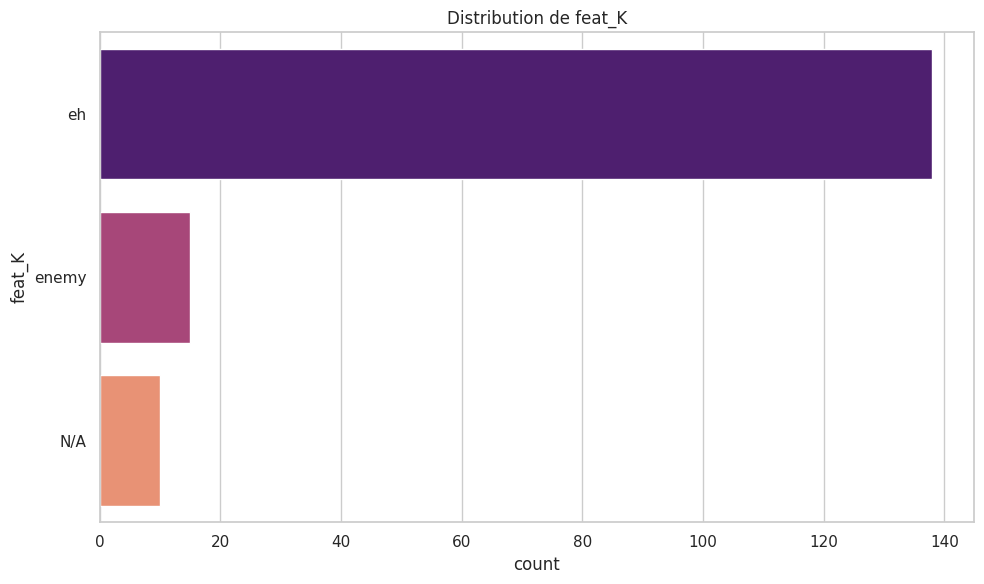


feat_L:
feat_L
numeric     0.552147
thinkpad    0.386503
N/A         0.061350
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


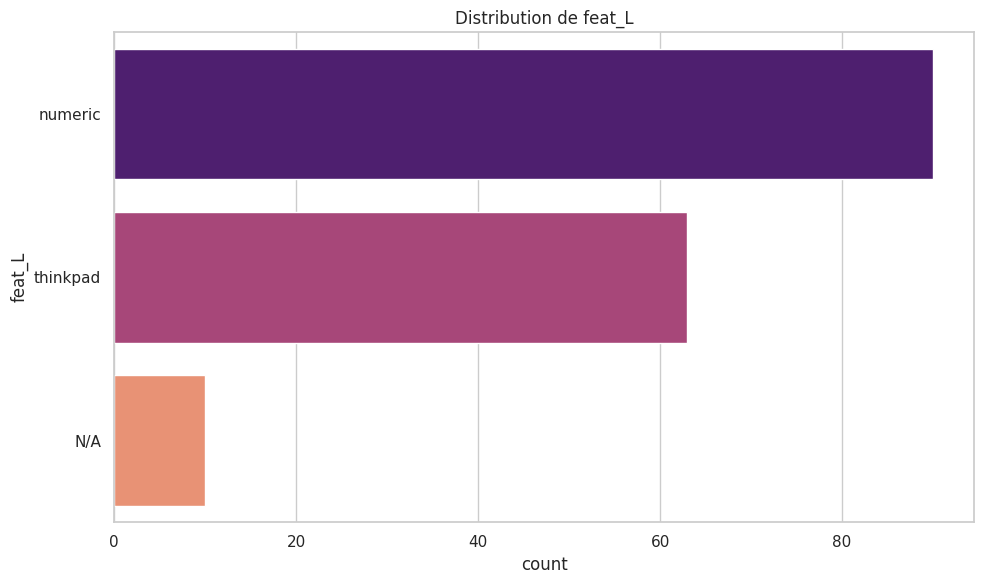


feat_M:
feat_M
legends    0.214724
belize     0.141104
lit        0.134969
wood       0.092025
N/A        0.092025
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


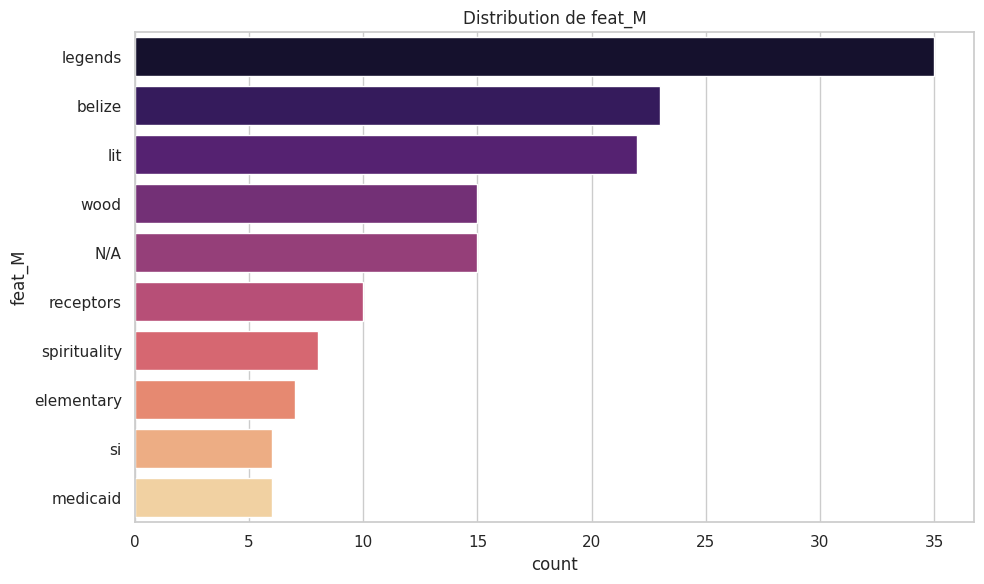


feat_N:
feat_N
N/A         0.460123
mountain    0.110429
waiver      0.110429
railroad    0.055215
cornwall    0.049080
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


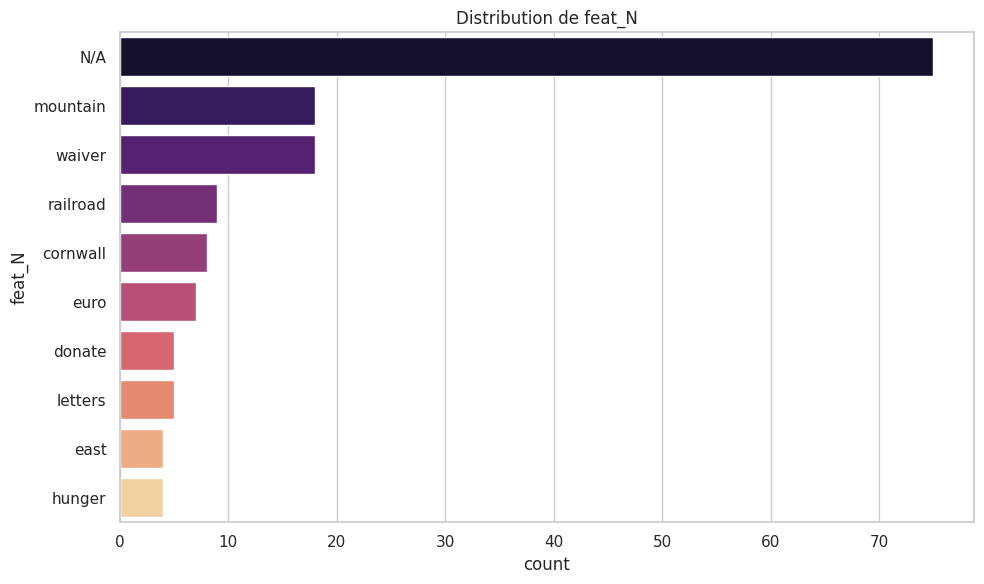


feat_O:
feat_O
N/A           0.760736
proxy         0.134969
remained      0.085890
authorized    0.018405
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


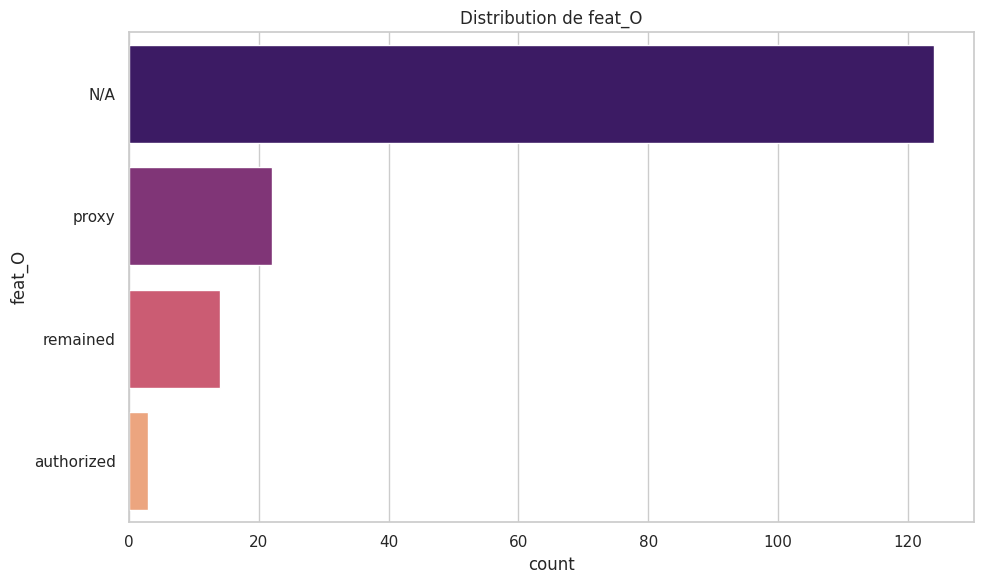


feat_P:
feat_P
N/A       0.840491
sees      0.079755
rage      0.067485
people    0.012270
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


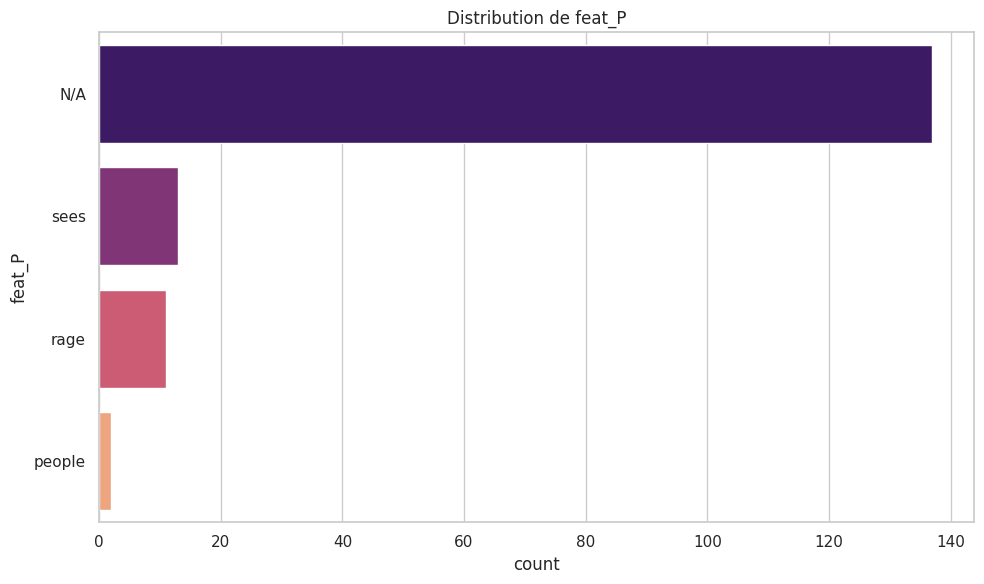


feat_Q:
feat_Q
until         0.257669
prairie       0.226994
conference    0.171779
applied       0.159509
N/A           0.134969
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


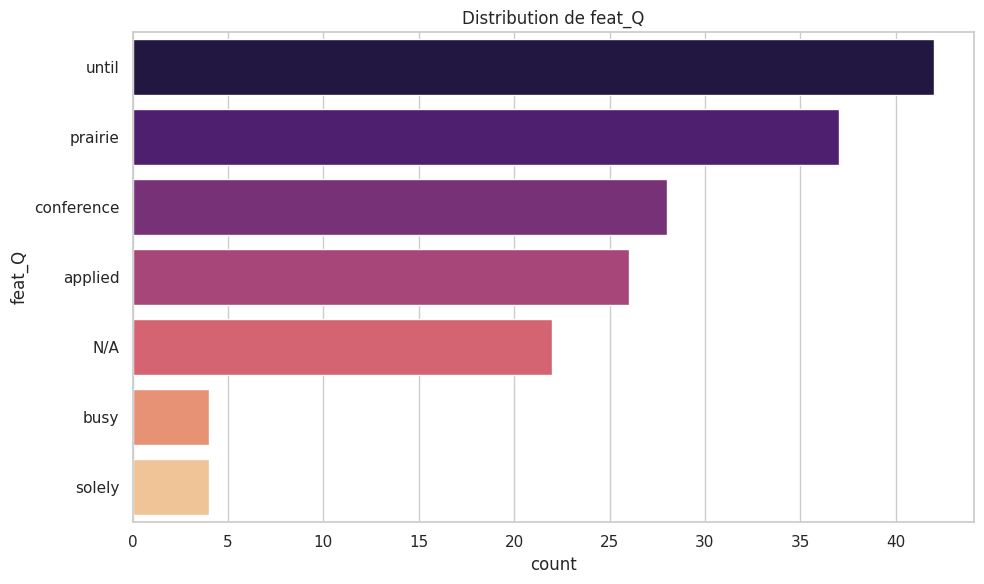


feat_R:
feat_R
N/A          0.453988
speed        0.190184
backup       0.184049
last         0.134969
aerospace    0.036810
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


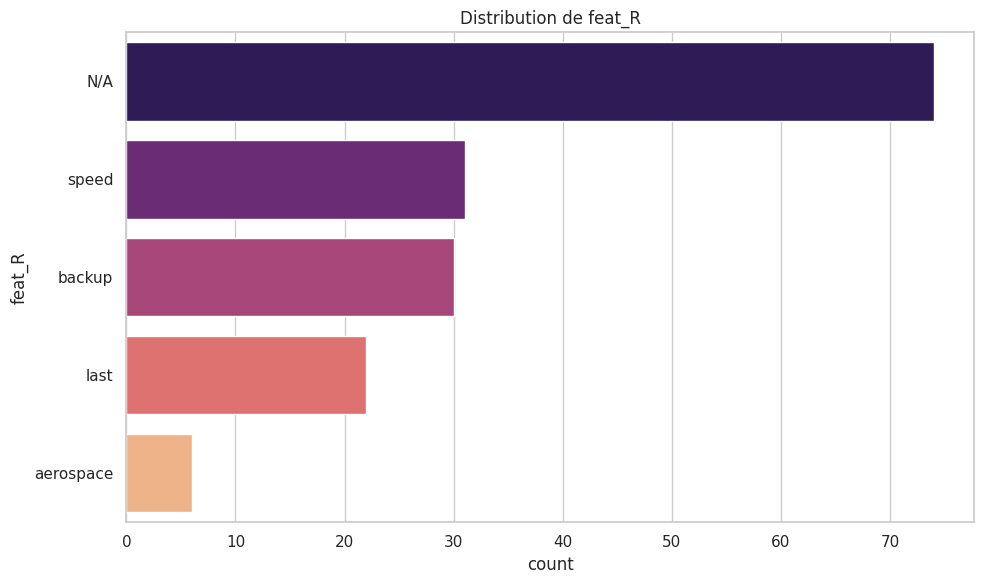


feat_S:
feat_S
creator    0.96319
centre     0.02454
N/A        0.01227
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


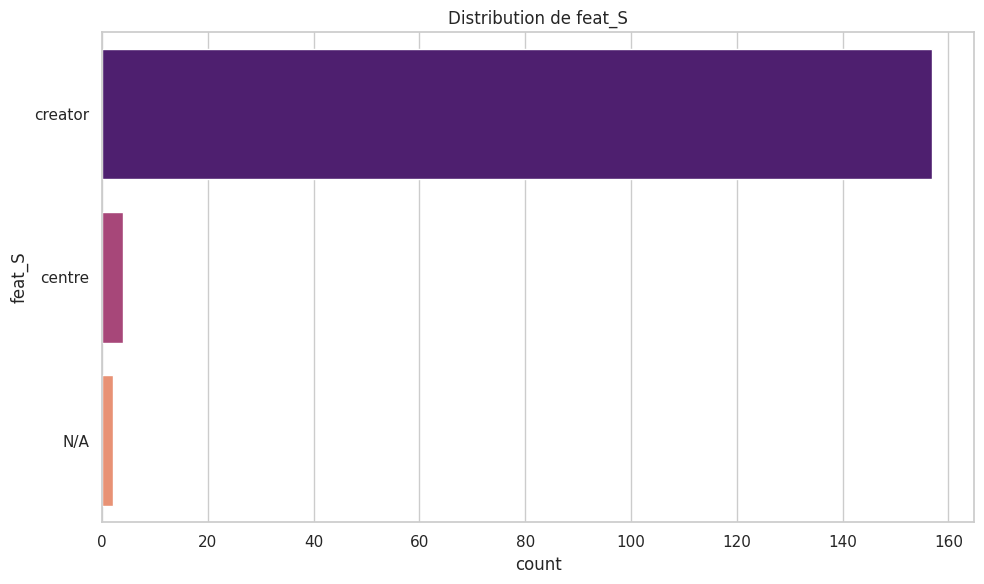


feat_T:
feat_T
dancing    0.92638
N/A        0.04908
chi        0.02454
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


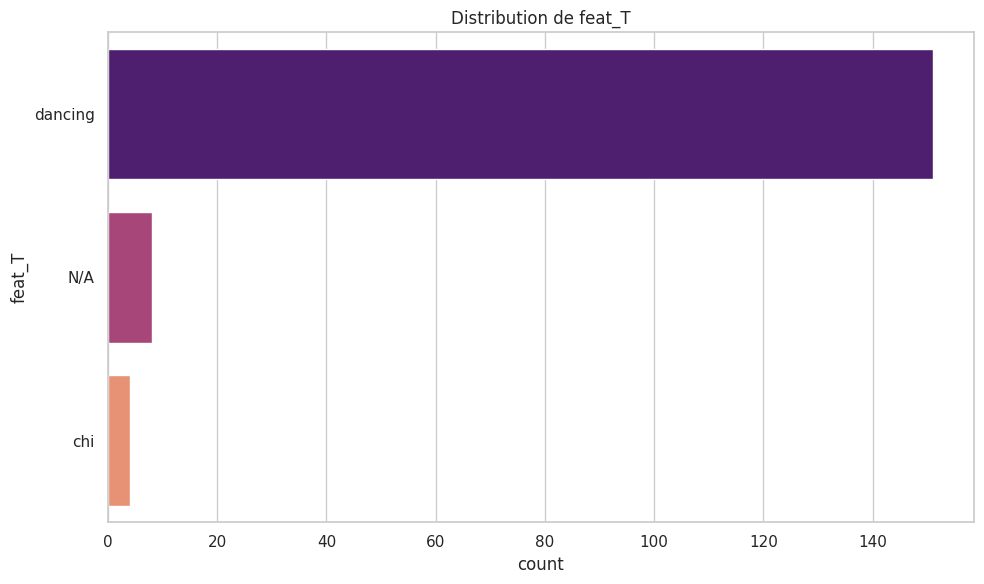


feat_U:
feat_U
enquiry      0.509202
renewable    0.398773
N/A          0.092025
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


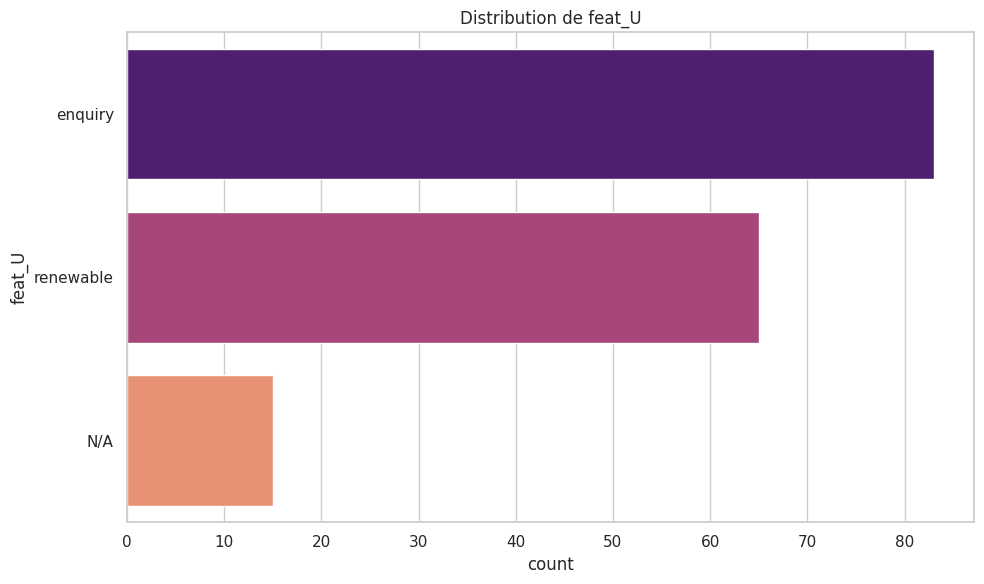


feat_V:
feat_V
N/A          0.441718
proposals    0.319018
decide       0.239264
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


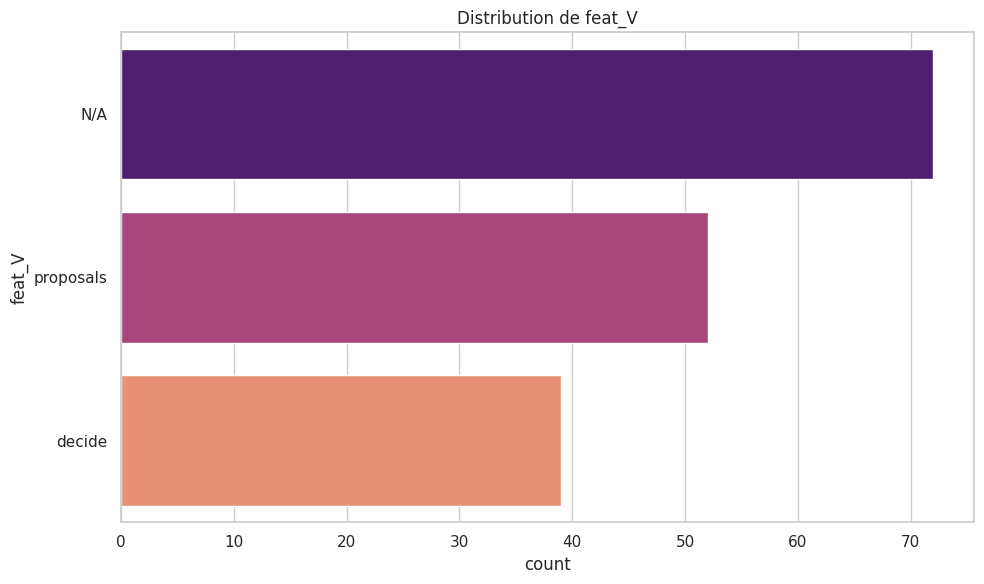


experiment_year:
experiment_year
2019    0.368098
2021    0.251534
2020    0.208589
2017    0.122699
2018    0.049080
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


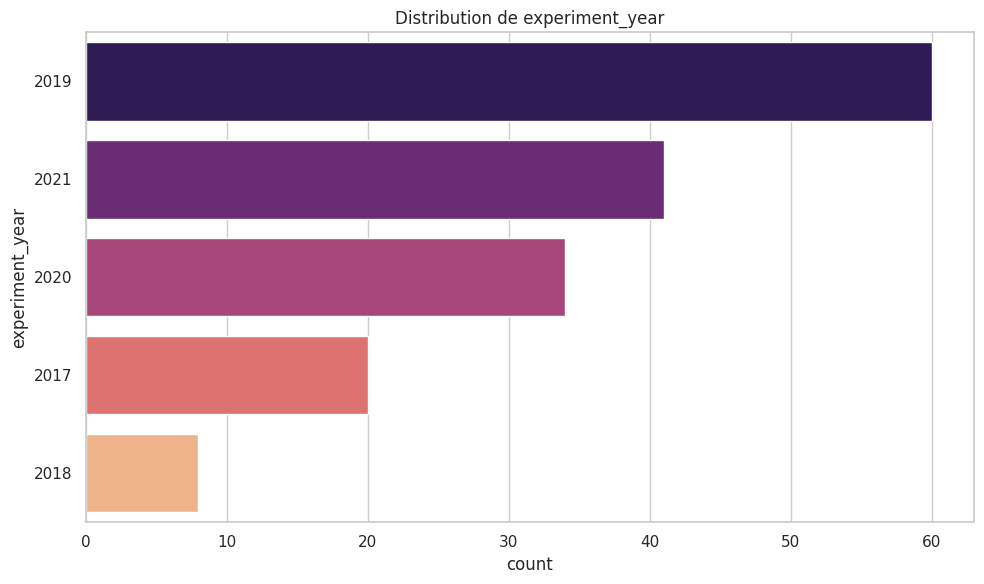


experiment_month:
experiment_month
11    0.171779
8     0.153374
9     0.134969
1     0.098160
6     0.085890
Name: proportion, dtype: float64


/tmp/ipython-input-29-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


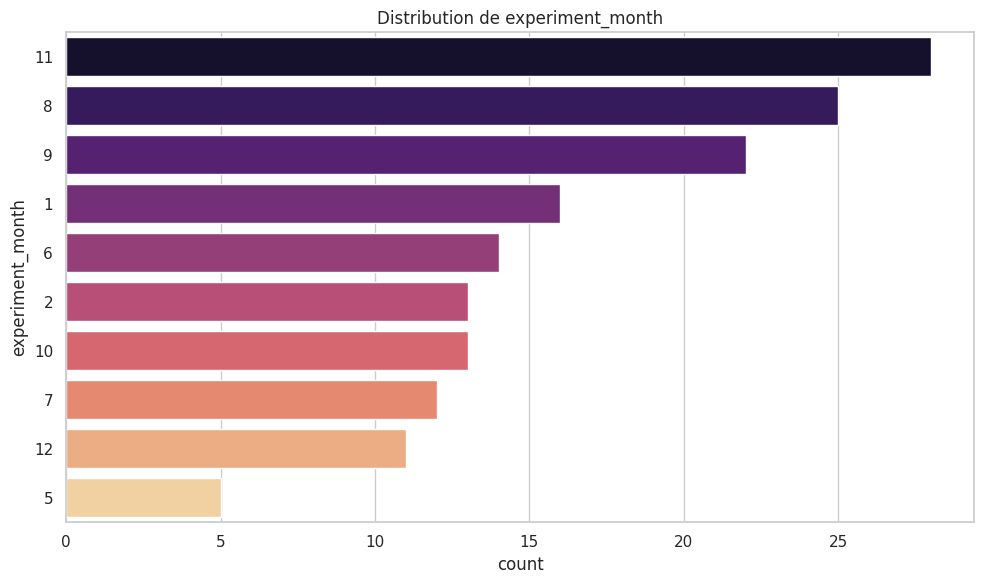

In [29]:
print("\nTop 5 des modalités par variable catégorielle:")
for var in cat_vars:
  print(f"\n{var}:")
  print(df[var].value_counts(normalize=True).head(5))
  # Visualisation des top modalités
  plt.figure(figsize=(10, 6))
  top_cats = df[var].value_counts().head(10).index
  sns.countplot(data=df, y=var, order=top_cats,palette='magma')
  #sns.countplot(data=df, y=var, order=top_cats, hue='hue_var', palette='magma', legend=False)
  plt.title(f'Distribution de {var}')
  plt.tight_layout()
  plt.savefig(f'distribution_{var}.png')
  plt.show()

**3. Réalisation d’une classification ascendante hiérarchique (CAH)**


In [30]:
# ----------------------------------------------------------
# 1. NETTOYAGE DES DONNÉES
# Remplace les NaN :
# - Par "absent" pour les colonnes catégorielles
# - Par 0 pour les colonnes numériques
# ----------------------------------------------------------
df_clean = df.copy()

for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].fillna("absent")
    else:
        df_clean[col] = df_clean[col].fillna(0)


In [31]:
# ----------------------------------------------------------
# 2. CALCUL DE LA MATRICE DE DISTANCE DE GOWER
# ----------------------------------------------------------
distance_matrix = gower.gower_matrix(df_clean)


In [32]:
# ----------------------------------------------------------
# 3. MÉTHODES D’AGRÉGATION À TESTER
# average : moyenne des distances
# complete : distance maximale
# single   : distance minimale
# ----------------------------------------------------------
methodes = ['average', 'complete', 'single']
Z_dict = {}  # Stocke les arbres de liaison



### 🔷 Méthode : AVERAGE ###


/tmp/ipython-input-33-1878236056.py:12: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method=methode)


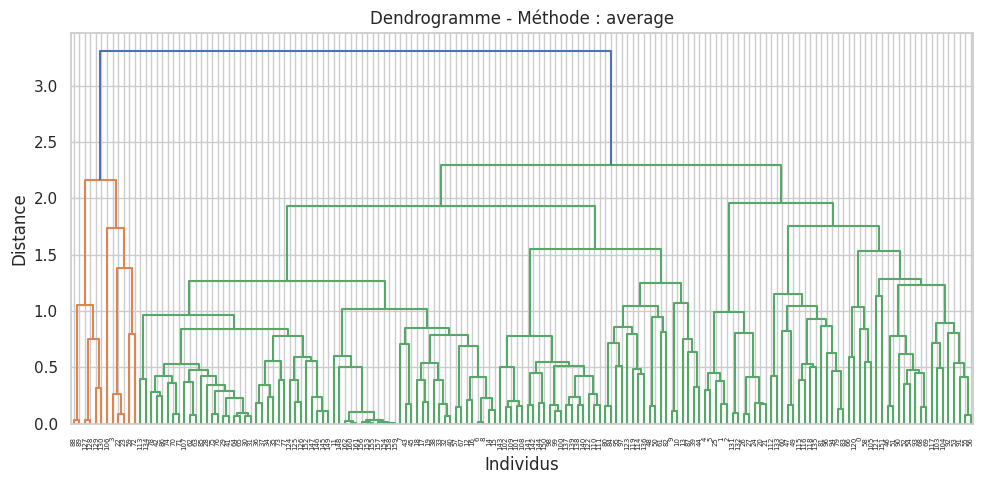

📊 Moyennes par cluster :
                       Y1           Y2
cluster_average                       
1                6.097467  1246.933333
2                5.254317   812.816667
3                4.454499   679.264673
4                3.575957   719.440952

👥 Effectif par cluster :
cluster_average
1      6
2      6
3    102
4     49
Name: count, dtype: int64


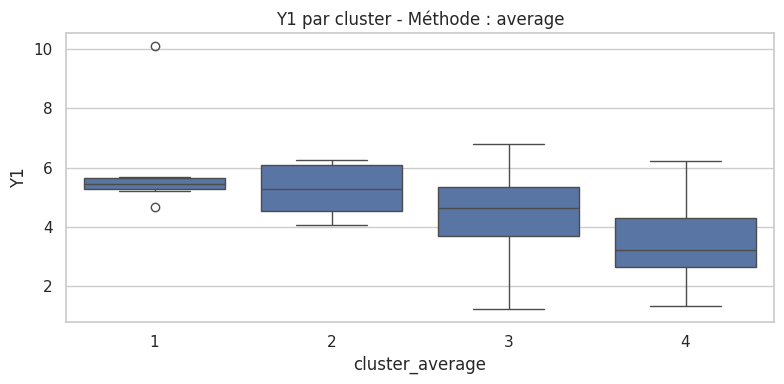

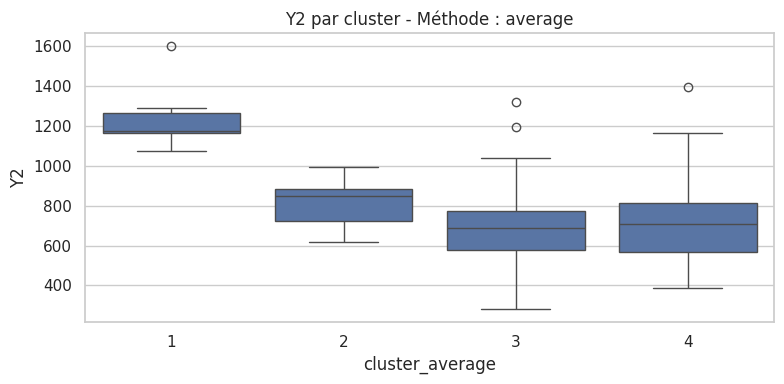


### 🔷 Méthode : COMPLETE ###


/tmp/ipython-input-33-1878236056.py:12: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method=methode)


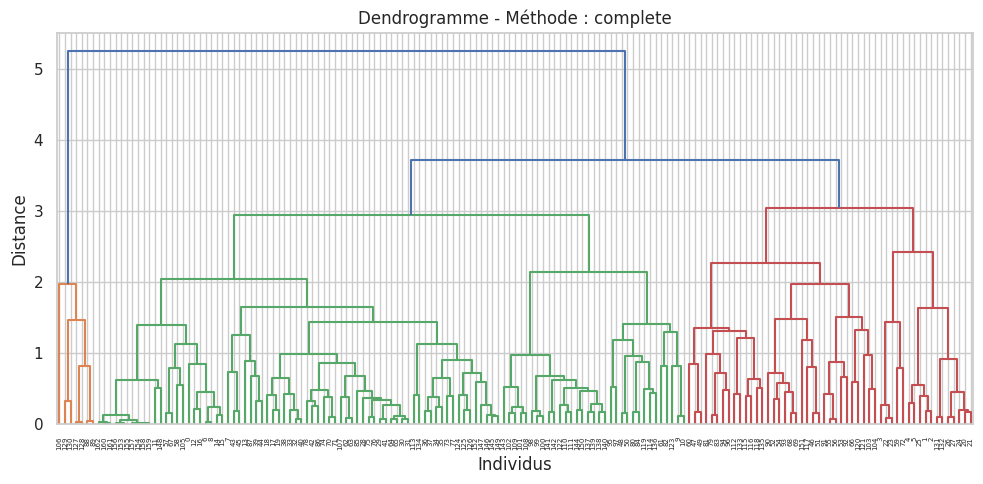

📊 Moyennes par cluster :
                        Y1           Y2
cluster_complete                       
1                 5.870800  1195.866667
2                 4.428268   678.914889
3                 3.011976   633.603627
4                 5.248271   923.320588

👥 Effectif par cluster :
cluster_complete
1      7
2    105
3     34
4     17
Name: count, dtype: int64


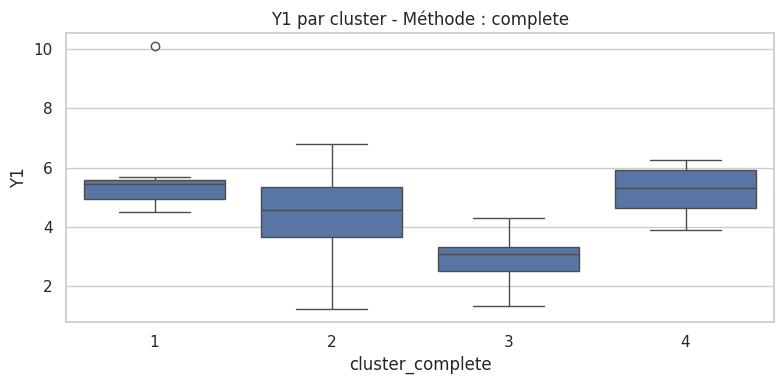

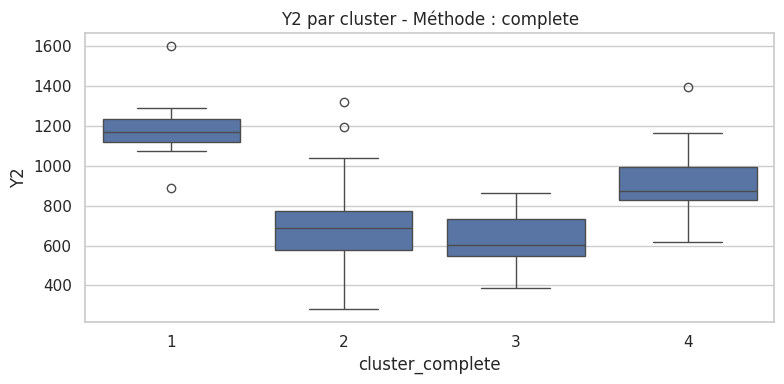


### 🔷 Méthode : SINGLE ###


/tmp/ipython-input-33-1878236056.py:12: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method=methode)


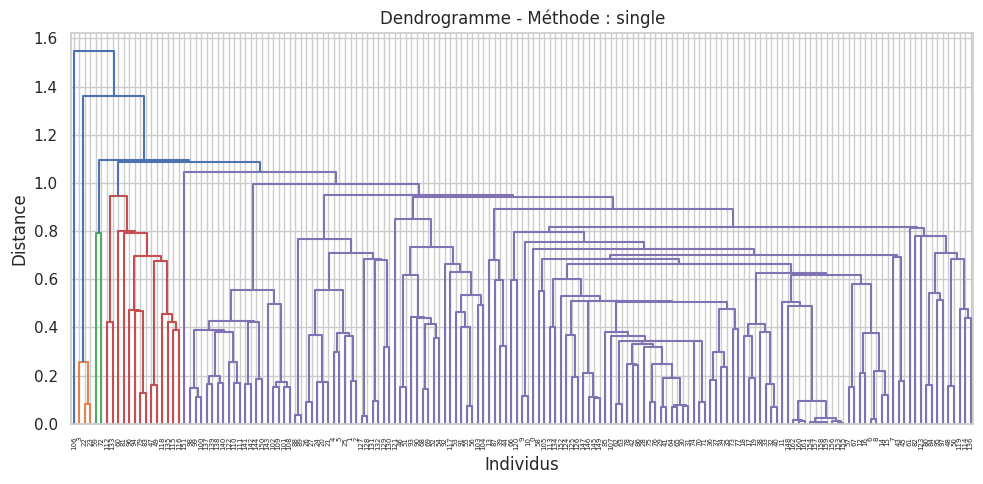

📊 Moyennes par cluster :
                      Y1          Y2
cluster_single                      
1               5.567567  845.833333
2               5.156200  724.966667
3               4.243093  713.498110
4               4.510800  889.466667

👥 Effectif par cluster :
cluster_single
1      3
2      2
3    157
4      1
Name: count, dtype: int64


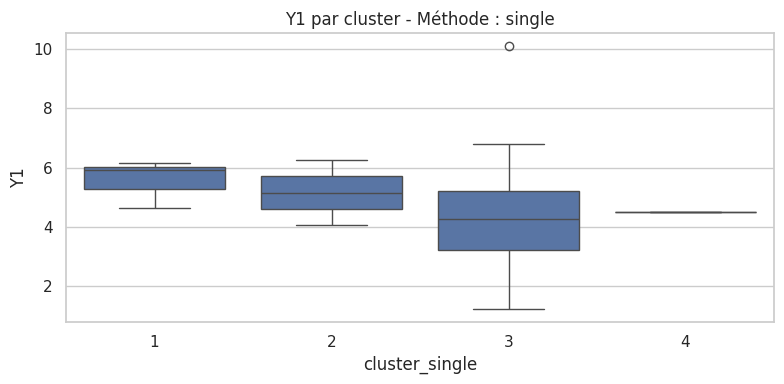

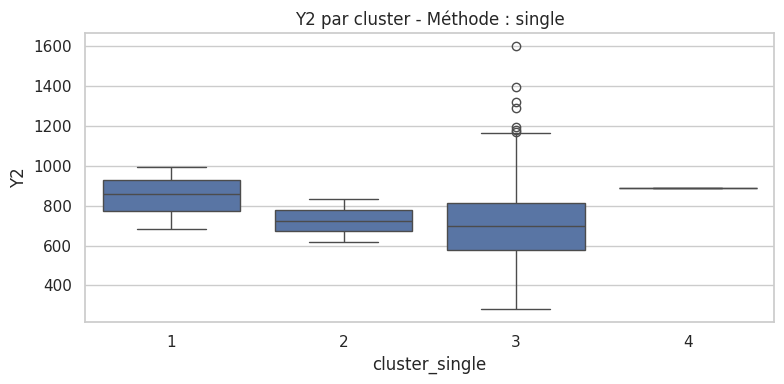

In [33]:
# ----------------------------------------------------------
# 4. BOUCLE SUR CHAQUE MÉTHODE D’AGRÉGATION
# - Génère le dendrogramme
# - Découpe en 4 clusters
# - Affiche les moyennes et effectifs
# - Affiche les boxplots
# ----------------------------------------------------------
for methode in methodes:
    print(f"\n### 🔷 Méthode : {methode.upper()} ###")

    # Création de l’arbre hiérarchique
    Z = linkage(distance_matrix, method=methode)
    Z_dict[methode] = Z  # Mémorise la structure

    # --- Dendrogramme ---
    plt.figure(figsize=(10, 5))
    dendrogram(Z, labels=df_clean.index, leaf_rotation=90)
    plt.title(f"Dendrogramme - Méthode : {methode}")
    plt.xlabel("Individus")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

    # --- Découpage en 4 clusters ---
    k = 4
    clusters = fcluster(Z, t=k, criterion='maxclust')
    df_clean[f'cluster_{methode}'] = clusters

    # --- Moyennes de Y1 et Y2 par cluster ---
    print("📊 Moyennes par cluster :")
    print(df_clean.groupby(f'cluster_{methode}')[['Y1', 'Y2']].mean())

    # --- Effectif des clusters ---
    print("\n👥 Effectif par cluster :")
    print(df_clean[f'cluster_{methode}'].value_counts().sort_index())

    # --- Boxplots pour Y1 et Y2 ---
    for y_var in ['Y1', 'Y2']:
        plt.figure(figsize=(8, 4))
        sns.boxplot(data=df_clean, x=f'cluster_{methode}', y=y_var)
        plt.title(f"{y_var} par cluster - Méthode : {methode}")
        plt.tight_layout()
        plt.show()



In [38]:
# --- 5. Graphiques de profil pour chaque méthode ---
for methode in methodes + ['ward']:
  cluster_col = f'cluster_{methode}'

if cluster_col  in df_clean.columns:
    profile = df_clean.groupby(cluster_col)[['Y1','Y2']].mean()
    plt.figure(figsize=(8, 4))
    profile.T.plot(kind='bar', ax=plt.gca())
    plt.title(f"Profil des clusters - Méthode : {methode}")
    plt.ylabel("Valeur moyenne")
    plt.xlabel("Variables")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

**`4. (Optionnel) Réalisation d’une analyse en composantes (ACP ou ACM)`**





4.1.Cas 1 : ACP (Analyse en Composantes Principales):
S’applique si toutes les variables sont numériques ou ont été transformées

Text(0, 0.5, 'PC2')

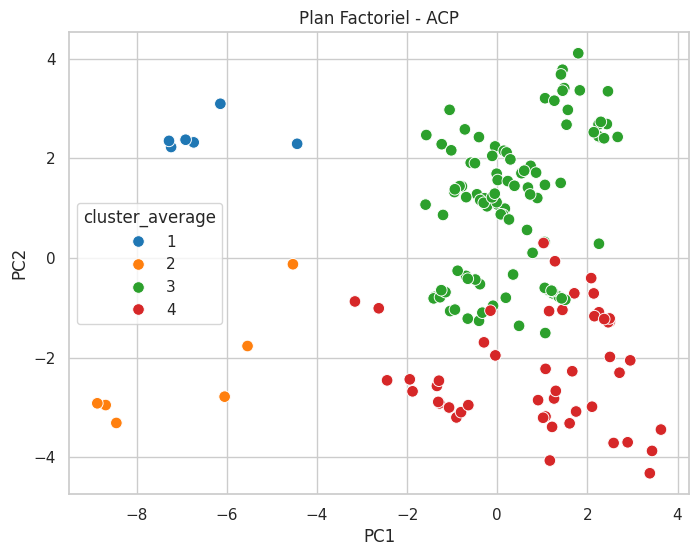

In [59]:
# -------------------------------------------------------
# 1. Sélection des variables numériques
# -------------------------------------------------------
df_num =df_clean.select_dtypes(include=[np.number])



# -------------------------------------------------------
# 2. Standardisation (très important pour l’ACP)
# -------------------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)


# -------------------------------------------------------
# 3. Réalisation de l’ACP
# -------------------------------------------------------

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Intégration des coordonnées principales
df_clean['PC1'] = X_pca[:, 0]
df_clean['PC2'] = X_pca[:, 1]


# -------------------------------------------------------
# 4. Visualisation du plan factoriel avec clusters existants
# -------------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot( x='PC1', y='PC2', hue='cluster_average',data=df_clean, palette='tab10', s=70)
plt.title('Plan Factoriel - ACP')
plt.xlabel('PC1')
plt.ylabel('PC2')




Cas 2 : ACM (Analyse des Correspondances Multiples):S’applique si les variables sont toutes ou majoritairement catégorielles

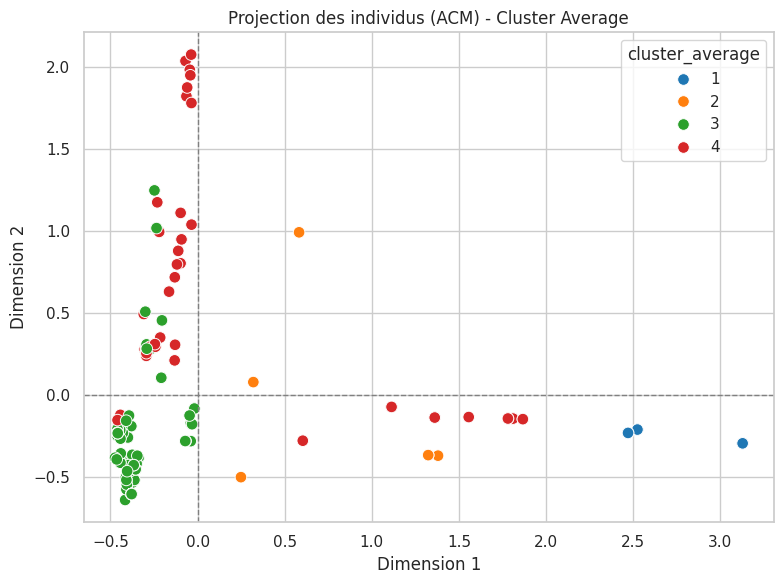

In [62]:
# -------------------------------------------------------
# 1. Sélection des variables qualitatives
# -------------------------------------------------------
df_cat = df_clean.select_dtypes(include='object')
# -------------------------------------------------------
# 2. Lancer l’ACM
# -------------------------------------------------------

acm = prince.MCA(n_components=2,random_state=42)
acm_fit = acm.fit(df_cat)
X_acm = acm_fit.transform(df_cat)

# Intégration des composantes
df_clean['ACM1'] = X_acm[X_acm.columns[0]]
df_clean['ACM2'] = X_acm[X_acm.columns[1]]


# -------------------------------------------------------
# 3. Visualisation des clusters sur plan ACM
# -------------------------------------------------------

plt.figure(figsize=(8,6))
sns.scatterplot( x='ACM1', y='ACM2', hue='cluster_average',data=df_clean, palette='tab10', s=70)
plt.title("Projection des individus (ACM) - Cluster Average")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.axhline(0, color='gray', linestyle='--',lw=1)
plt.axvline(0, color='gray', linestyle='--',lw=1)
plt.tight_layout()
plt.show()






**5. Interprétation et conclusions**


*   Décrivez et comparez les groupes obtenus






Les clusters ont été formés à partir des données en utilisant différentes méthodes (ACP et ACM). Voici une synthèse des clusters basée sur la méthode cluster_average :


Cluster 1 (6 observations) :

Performances : Y1 moyen = 6.10 (le plus élevé), Y2 moyen = 1246.93 (le plus élevé).

Caractéristiques : Ce cluster représente les conceptions les plus performantes. Les valeurs élevées de Y1 et Y2 suggèrent que ces configurations sont optimales.

Exemples : Conceptions avec des valeurs élevées pour feat_A, feat_D, et des combinaisons spécifiques de variables catégorielles comme feat_G = "competition", feat_H = "switching", etc.

Cluster 2 (6 observations) :

Performances : Y1 moyen = 5.25, Y2 moyen = 812.82.

Caractéristiques : Performances intermédiaires. Ces conceptions sont moins performantes que le Cluster 1 mais plus que les Clusters 3 et 4.

Exemples : Certaines combinaisons de feat_G = "myers" ou feat_G = "size" avec des valeurs moyennes pour les autres features.

Cluster 3 (102 observations) :

Performances : Y1 moyen = 4.45, Y2 moyen = 679.26.

Caractéristiques : Le cluster le plus peuplé, représentant des conceptions avec des performances moyennes à faibles.

Exemples : Conventions avec des valeurs moyennes pour feat_A et feat_D, et des combinaisons courantes de variables catégorielles comme feat_G = "myers".

Cluster 4 (49 observations) :

Performances : Y1 moyen = 3.58 (le plus faible), Y2 moyen = 719.44.

Caractéristiques : Performances globalement faibles, mais avec une légère augmentation de Y2 par rapport au Cluster 3.

Exemples : Conceptions avec des valeurs faibles pour feat_A et feat_D, et des combinaisons moins courantes de variables catégorielles.



*   Analyse des Relations avec Y1 et Y2

Y1 : Les clusters avec des valeurs élevées de Y1 (Cluster 1 et 2) sont associés à des combinaisons spécifiques de features, notamment des valeurs élevées pour feat_A et feat_D. Ces features semblent avoir un impact positif sur Y1.

Y2 : Les clusters avec des valeurs élevées de Y2 (Cluster 1) sont également associés à des valeurs élevées de feat_D et certaines combinaisons catégorielles comme feat_G = "competition". Cependant, Y2 semble moins corrélé avec feat_A que Y1.






*    Usage Potentiel des Résultats pour le Métier

Nouvelles Conceptions Proches des Groupes Performants :

Les conceptions du Cluster 1 (hautes performances) pourraient servir de référence pour de nouvelles conceptions. Par exemple, privilégier les combinaisons où feat_G = "competition", feat_H = "switching", et feat_D est élevé.

Explorer les valeurs de feat_A et feat_D dans les clusters performants pour reproduire leurs effets.

Classes à Écarter :

Les conceptions du Cluster 4 (faibles performances) devraient être évitées ou modifiées. Par exemple, les combinaisons avec des valeurs faibles de feat_A et feat_D semblent moins efficaces.

Les conceptions où feat_G = "size" ou certaines combinaisons avec feat_M = "belize" sont associées à de moins bonnes performances.

Optimisation :

Pour améliorer Y1, se concentrer sur l'augmentation de feat_A et feat_D.

Pour améliorer Y2, explorer les combinaisons catégorielles du Cluster 1 et vérifier leur applicabilité dans d'autres contextes.

